In [6]:
%pip install numpy pyvista PIL matplotlib scipy pandas seaborn scikit-learn statsmodels plotly

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached pyvista-0.44.2-py3-none-any.whl (2.2 MB)


In [14]:
%pip install pyvista graphviz dtreeviz.trees

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement dtreeviz.trees (from versions: none)
ERROR: No matching distribution found for dtreeviz.trees

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


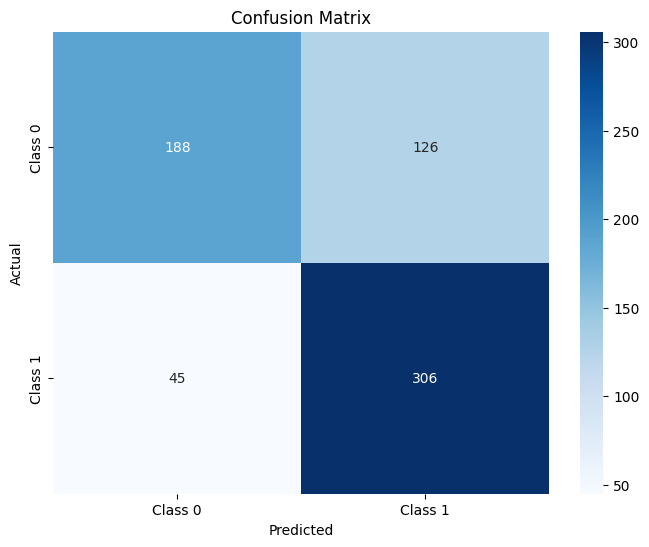

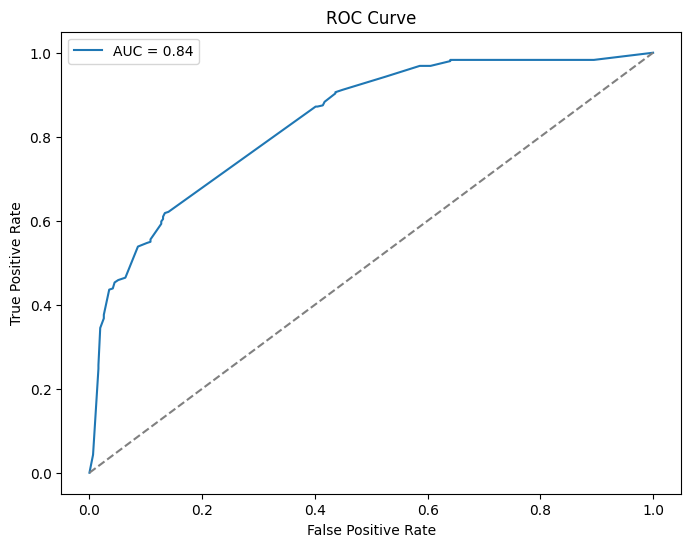

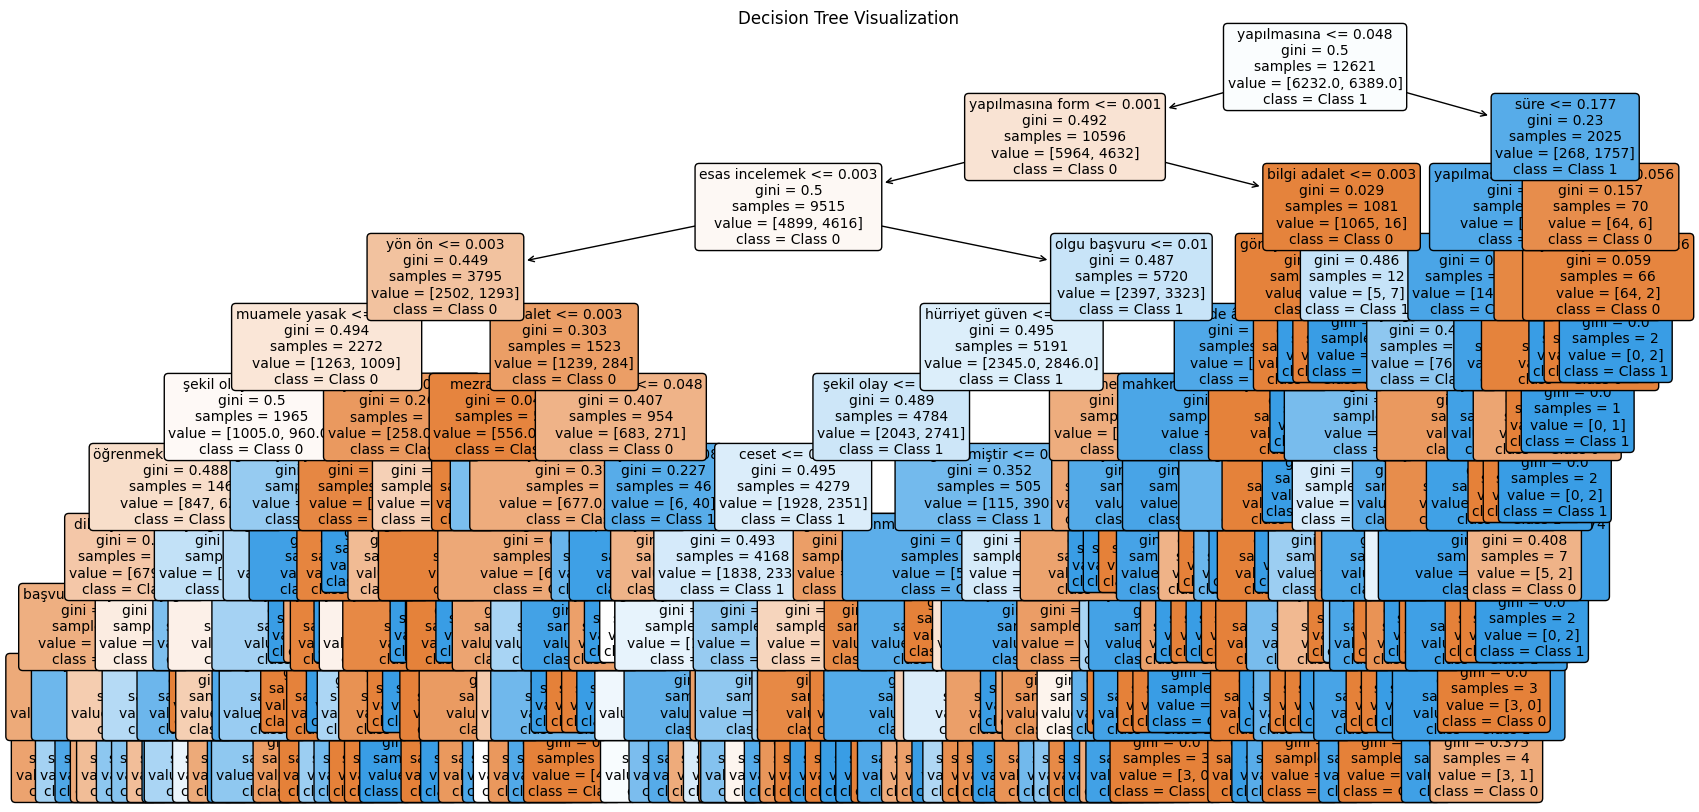

Accuracy: 0.74
Cross-Validation Scores: [0.72277228 0.7274168  0.73137876 0.74167987 0.75158479]
Mean CV Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.81      0.60      0.69       314
     Class 1       0.71      0.87      0.78       351

    accuracy                           0.74       665
   macro avg       0.76      0.74      0.73       665
weighted avg       0.75      0.74      0.74       665

ROC-AUC Score: 0.84


In [15]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))

# Load datasets
train_data = load_json_data('train_processed.json')
development_data = load_json_data('dev_processed.json')
test_data = load_json_data('test_processed.json')

# Extract features and labels for all datasets
def prepare_features_and_labels(data, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        features = vectorizer.fit_transform(data['text'])
    else:
        features = vectorizer.transform(data['text'])
    labels = data['labels']
    return features, labels, vectorizer

# Prepare features and labels
X_train, y_train, vectorizer = prepare_features_and_labels(train_data)
X_dev, y_dev, _ = prepare_features_and_labels(development_data, vectorizer)
X_test, y_test, _ = prepare_features_and_labels(test_data, vectorizer)

# Combine training and development data for final model training
X_combined = np.vstack([X_train.toarray(), X_dev.toarray()])
y_combined = np.hstack([y_train, y_dev])

# Train Decision Tree model
model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, criterion='gini', random_state=42)
model.fit(X_combined, y_combined)

# Model Evaluation
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1'])
roc_auc = roc_auc_score(y_test, probabilities)

# Cross-Validation (for robustness)
cross_val_scores = cross_val_score(model, X_combined, y_combined, cv=5, scoring='accuracy')

# Visualizations

## Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Visualize decision tree using matplotlib
plt.figure(figsize=(20, 10))
plot_tree(
    model, 
    feature_names=vectorizer.get_feature_names_out(), 
    class_names=["Class 0", "Class 1"], 
    filled=True, 
    rounded=True, 
    fontsize=10
)
plt.title('Decision Tree Visualization')
plt.show()

# Export decision rules as text
rules = export_text(model, feature_names=vectorizer.get_feature_names_out())
with open('decision_tree_rules.txt', 'w', encoding='utf-8') as file:
    file.write(rules)

# Save processed datasets
train_data.to_json('processed_training_dataset.json', orient='records', force_ascii=False)
development_data.to_json('processed_development_dataset.json', orient='records', force_ascii=False)
test_data.to_json('processed_testing_dataset.json', orient='records', force_ascii=False)

# Performance Summary
print(f"Accuracy: {accuracy:.2f}")
print("Cross-Validation Scores:", cross_val_scores)
print(f"Mean CV Accuracy: {np.mean(cross_val_scores):.2f}")
print("Classification Report:\n", class_report)
print(f"ROC-AUC Score: {roc_auc:.2f}")
